In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from matplotlib.colors import ListedColormap
from pydotplus import graph_from_dot_data

In [2]:
iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target
print('Class labels:', np.unique(y))
iris.feature_names

Class labels: [0 1 2]


['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [4]:
print('Number of labels in y:', np.bincount(y))
print('Number of labels in y_train:', np.bincount(y_train))
print('Number of labels in y_test:', np.bincount(y_test))

Number of labels in y: [50 50 50]
Number of labels in y_train: [35 35 35]
Number of labels in y_test: [15 15 15]


In [5]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [6]:
ppn = Perceptron(max_iter=1000, tol=1e-3, eta0=0.1, random_state=1)
ppn.fit(X_train_std, y_train)

Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=0.1,
           fit_intercept=True, max_iter=1000, n_iter_no_change=5, n_jobs=None,
           penalty=None, random_state=1, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)

In [7]:
y_train_pred = ppn.predict(X_train_std)
y_test_pred = ppn.predict(X_test_std)

In [8]:
print('Incorrectly classified examples (train): %d' % (y_train_pred != y_train).sum())
print('Incorrectly classified examples (test): %d' % (y_test_pred != y_test).sum())

Incorrectly classified examples (train): 6
Incorrectly classified examples (test): 1


In [9]:
print('Accuracy (train): %.2f' % accuracy_score(y_train_pred, y_train))
print('Accuracy (test): %.2f' % accuracy_score(y_test_pred, y_test))

Accuracy (train): 0.94
Accuracy (test): 0.98


In [10]:
print('Accuracy (train): %.2f' % ppn.score(X_train_std, y_train))
print('Accuracy (test): %.2f' % ppn.score(X_test_std, y_test))

Accuracy (train): 0.94
Accuracy (test): 0.98


In [11]:
def versiontuple(v):
    return tuple(map(int, (v.split('.'))))

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    #print(Z)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1], alpha=0.8, c=colors[idx],
                    marker=markers[idx], label=cl, edgecolor='black')
    
    if test_idx:
        X_test, y_test = X[list(test_idx), :], y[list(test_idx)]
        
        plt.scatter(X_test[:, 0], X_test[:, 1], c='', edgecolor='black',
                    alpha=1.0, linewidth=1, marker='o', edgecolors='k',
                    s=100, label='Test set')

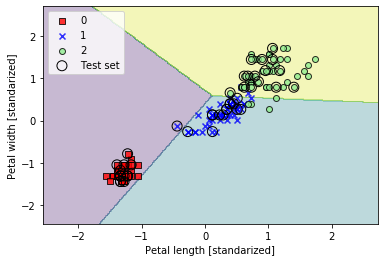

In [12]:
X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X=X_combined_std, y=y_combined, classifier=ppn,
                      test_idx=range(105, 150))
plt.xlabel('Petal length [standarized]')
plt.ylabel('Petal width [standarized]')
plt.legend(loc='upper left')
plt.show()

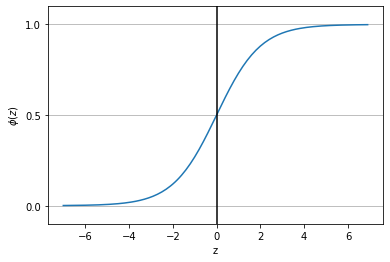

In [13]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

z = np.arange(-7, 7, 0.1)
phi_z = sigmoid(z)

plt.plot(z, phi_z)
plt.axvline(0.0, color='k')
plt.ylim(-0.1, 1.1)
plt.yticks([0.0, 0.5, 1.0])
plt.ylabel('$\phi (z)$')
plt.xlabel('z')
ax = plt.gca()
ax.yaxis.grid(True)
plt.show()

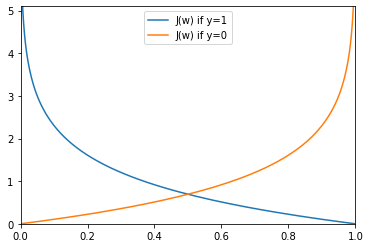

In [14]:
def cost_1(z):
    return -np.log(sigmoid(z))

def cost_0(z):
    return -np.log(1 - sigmoid(z))

z = np.arange(-10, 10, 0.1)
phi_z = sigmoid(z)

c1 = [cost_1(x) for x in z]
c0 = [cost_0(x) for x in z]
plt.plot(phi_z, c1, label='J(w) if y=1')
plt.plot(phi_z, c0, label='J(w) if y=0')
plt.ylim(0.0, 5.1)
plt.xlim(0.0, 1.0)
plt.legend(loc='upper center')
plt.show()

In [15]:
class LogisticRegressionGD(object):
    def __init__(self, eta=0.01, n_iter=100, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
        
    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        
        self.cost_ = []
        
        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            
            cost = np.dot(-y, np.log(output)) - np.dot((1 - y), np.log(1 - output))
            self.cost_.append(cost)
        return self
    
    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def activation(self, z):
        return 1.0 / (1.0 + np.exp(-np.clip(z, -250, 250)))
    
    def predict(self, X):
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)

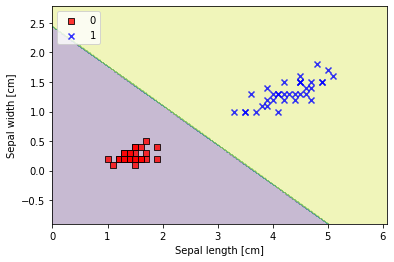

In [16]:
pos = y_train == 1
neg = y_train == 0

X_train_binary = X_train[pos | neg]
y_train_binary = y_train[pos | neg]

lrgd = LogisticRegressionGD(eta=0.01, n_iter=1000)
lrgd.fit(X_train_binary, y_train_binary)

plot_decision_regions(X=X_train_binary, y=y_train_binary, classifier=lrgd)
plt.xlabel('Sepal length [cm]')
plt.ylabel('Sepal width [cm]')
plt.legend(loc='upper left')
plt.show()

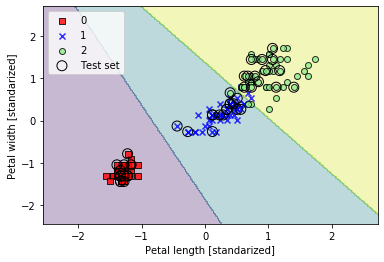

In [17]:
lr = LogisticRegression(C=1000.0, solver='lbfgs', multi_class='ovr', random_state=1)
lr.fit(X_train_std, y_train)
plot_decision_regions(X=X_combined_std, y=y_combined, classifier=lr,
                      test_idx=range(105, 150))
plt.xlabel('Petal length [standarized]')
plt.ylabel('Petal width [standarized]')
plt.legend(loc='upper left')
plt.show()

In [18]:
display(lr.predict_proba(X_test_std[:3, :]))
display(lr.predict_proba(X_test_std[:3, :]).sum(axis=1))
display(lr.predict_proba(X_test_std[:3, :]).argmax(axis=1))
display(lr.predict(X_test_std[:3, :]))

array([[2.40380030e-12, 1.42935558e-01, 8.57064442e-01],
       [8.35119180e-01, 1.64880820e-01, 2.02061631e-16],
       [8.49517113e-01, 1.50482887e-01, 8.37714326e-18]])

array([1., 1., 1.])

array([2, 0, 0], dtype=int64)

array([2, 0, 0])

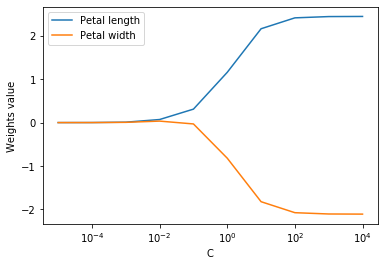

In [19]:
weights, params = [], []
for c in np.arange(-5, 5):
    lr = LogisticRegression(C=10.0**c, solver='lbfgs', multi_class='ovr', random_state=1)
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[1])
    params.append(10.0**c)
weights = np.array(weights)
plt.plot(params, weights[:, 0], label='Petal length')
plt.plot(params, weights[:, 1], label='Petal width')

plt.xlabel('C')
plt.ylabel('Weights value')
plt.legend(loc='upper left')
plt.xscale('log')

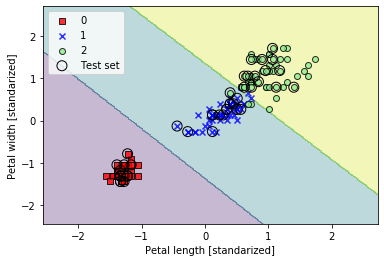

In [20]:
svm = SVC(kernel='linear', C=1.0, random_state=1)
svm.fit(X_train_std, y_train)
plot_decision_regions(X=X_combined_std, y=y_combined, classifier=svm,
                      test_idx=range(105, 150))
plt.xlabel('Petal length [standarized]')
plt.ylabel('Petal width [standarized]')
plt.legend(loc='upper left')
plt.show()

In [21]:
ppn = SGDClassifier(loss='perceptron')
lr = SGDClassifier(loss='log')
ppn = SGDClassifier(loss='hinge')

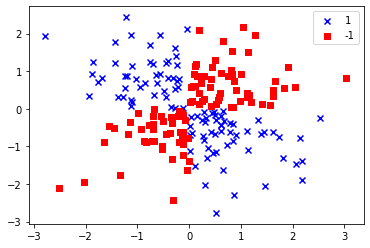

In [22]:
np.random.seed(1)
X_xor = np.random.randn(200, 2)
y_xor = np.logical_xor(X_xor[:, 0] > 0, X_xor[:, 1] > 0)
y_xor = np.where(y_xor, 1, -1)
plt.scatter(X_xor[y_xor == 1, 0], X_xor[y_xor == 1, 1],
            color='blue', marker='x', label='1')
plt.scatter(X_xor[y_xor == -1, 0], X_xor[y_xor == -1, 1],
            color='red', marker='s', label='-1')
plt.legend(loc='best')
plt.show()

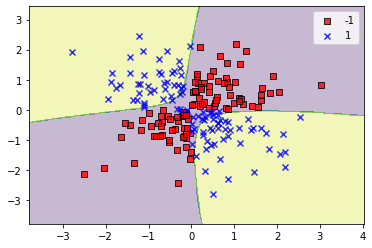

In [23]:
svm = SVC(kernel='rbf', random_state=1, gamma=0.1, C=10)
svm.fit(X_xor, y_xor)
plot_decision_regions(X=X_xor, y=y_xor, classifier=svm)
plt.legend(loc='upper right')
plt.show()

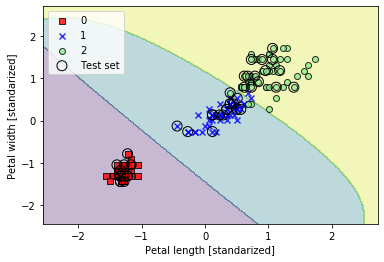

In [24]:
svm = SVC(kernel='rbf', gamma=0.2, C=1.0, random_state=1)
svm.fit(X_train_std, y_train)
plot_decision_regions(X=X_combined_std, y=y_combined, classifier=svm,
                      test_idx=range(105, 150))
plt.xlabel('Petal length [standarized]')
plt.ylabel('Petal width [standarized]')
plt.legend(loc='upper left')
plt.show()

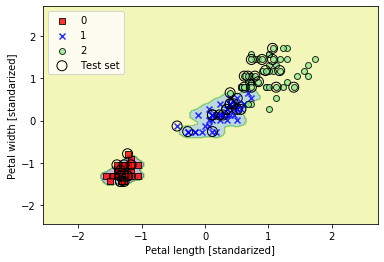

In [25]:
svm = SVC(kernel='rbf', gamma=100, C=1.0, random_state=1)
svm.fit(X_train_std, y_train)
plot_decision_regions(X=X_combined_std, y=y_combined, classifier=svm,
                      test_idx=range(105, 150))
plt.xlabel('Petal length [standarized]')
plt.ylabel('Petal width [standarized]')
plt.legend(loc='upper left')
plt.show()

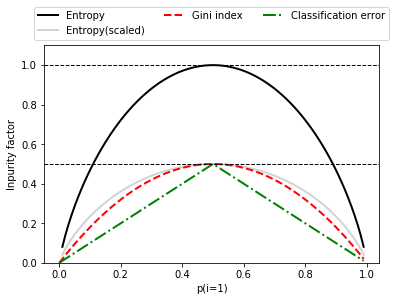

In [26]:
def gini(p):
    return 1 - (p**2 + (1 - p)**2)
def entropy(p):
    return -(p*np.log2(p) + (1 - p)*np.log2(1 - p)) 
def classification_error(p):
    return 1 - np.max([p, (1 - p)])
x = np.arange(0.0, 1, 0.01)
ent = [entropy(p) if p !=0 else None for p in x]
sc_ent = [e*0.5 if e else None for e in ent]
err = [classification_error(p) for p in x]
gin = [gini(p) for p in x]

fig, ax = plt.subplots()
for i, lab, ls, c, in zip([ent, sc_ent, gin, err],
                    ['Entropy', 'Entropy(scaled)', 'Gini index', 'Classification error'],
                    ['-', '-', '--', '-.'],
                    ['black', 'lightgray', 'red', 'green']):
    line = ax.plot(x, i, label=lab, linestyle=ls, lw=2, color=c)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.20), ncol=3,
          fancybox=True, shadow=False)
ax.axhline(y=0.5, linewidth=1, color='k', linestyle='--')
ax.axhline(y=1, linewidth=1, color='k', linestyle='--')
ax.set_ylim(0, 1.1)
ax.set_xlabel('p(i=1)')
ax.set_ylabel('Inpurity factor')
plt.show()

In [27]:
a = zip([ent, sc_ent, gin, err],
                          ['Entropy', 'Entropy(scaled)', 'Gini index', 'Classification error'],
                          ['-', '-', '--', '-.'],
                          ['black', 'lightgray', 'red', 'green'])

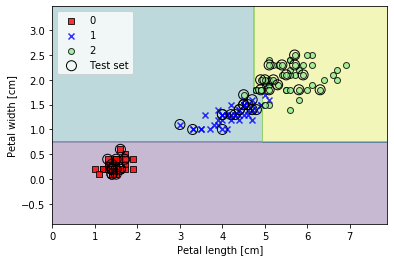

In [28]:
tree = DecisionTreeClassifier(criterion='gini', max_depth=4, random_state=1)
tree.fit(X_train, y_train)
X_combined = np.vstack([X_train, X_test])
y_combined = np.hstack([y_train, y_test])
plot_decision_regions(X=X_combined, y=y_combined, classifier=tree,
                      test_idx=range(105, 150))
plt.xlabel('Petal length [cm]')
plt.ylabel('Petal width [cm]')
plt.legend(loc='upper left')
plt.show()

In [29]:
dot_data = export_graphviz(tree, filled=True, rounded=True,
                           class_names=['Setosa', 'Versicolor', 'Virginica'],
                           feature_names=['Petal length [cm]', 'Petal width [cm]'],
                           out_file=None)

In [30]:
graph = graph_from_dot_data(dot_data)
graph.write_png('tree.png')
#graph.create_fig
#Image(graph.write_jpg('tree.jpg'))

InvocationException: GraphViz's executables not found

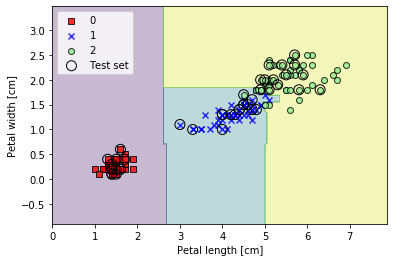

In [50]:
forest = RandomForestClassifier(criterion='gini', n_estimators=25, random_state=1, n_jobs=2)
forest.fit(X_train, y_train)
plot_decision_regions(X=X_combined, y=y_combined, classifier=forest,
                      test_idx=range(105, 150))
plt.xlabel('Petal length [cm]')
plt.ylabel('Petal width [cm]')
plt.legend(loc='upper left')
plt.show()

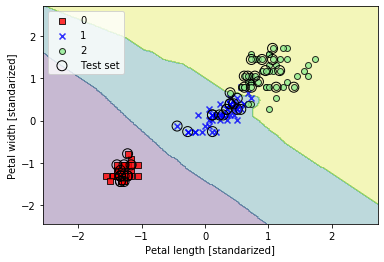

In [54]:
knn = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski')
knn.fit(X_train_std, y_train)
plot_decision_regions(X=X_combined_std, y=y_combined, classifier=knn,
                      test_idx=range(105, 150))
plt.xlabel('Petal length [standarized]')
plt.ylabel('Petal width [standarized]')
plt.legend(loc='upper left')
plt.show()